# Linear Dynamic Harmonic Regression (LDHR)

__Parece que los notebooks no están muy perfecionados (o mi instalación tiene problemas). Algunos comandos fallan la primera vez que se ejecutan.__

Para el filtrado (filtro de Kalman y suavizado de intervalo fijo) usaremos la toolbok [E4](https://www.ucm.es/e-4/), para ello es necesario ejecutar lo siguiente:

In [23]:
e4init


            XXXXXX 4 4      XXXXX  XX     XX  XX  XXXXXX (c)
           XX      444     XX  XX XX     XX  XX  XX
          XXXX       4    XXXXX  XX     XX  XX  XXXXXX
         XX              XX     XX     XX  XX      XX
        XXXXXX          XX     XXXXXX XXXXXX  XXXXXX

    Toolbox for State Space Estimation of Econometric Models
 
*********************** Options set by user ********************
Filter. . . . . . . . . . . . . : KALMAN
Scaled B and M matrices . . . . : NO
Initial state vector. . . . . . : AUTOMATIC SELECTION
Initial covariance of state v.  : IDEJONG
Variance or Cholesky factor?  . : VARIANCE
Optimization algorithm. . . . . : BFGS
Maximum step length . . . . . . : 0.100000
Stop tolerance. . . . . . . . . : 0.000010
Max. number of iterations . . . :       75
Verbose iterations. . . . . . . : YES
****************************************************************
 
 


Tambien es necesario cargar el toolbox de control

In [24]:
pkg load control

Cargamos los datos de la serie _"lineas aéreas"_

In [25]:
load airpas

Por comodidad vamos a generar la variable 'y' con los mismos datos (es más cómodo escribir `y` que escribir `airpas`)

In [26]:
y = airpas;

y ahora vamos a representar los datos de la serie de líneas aéreas

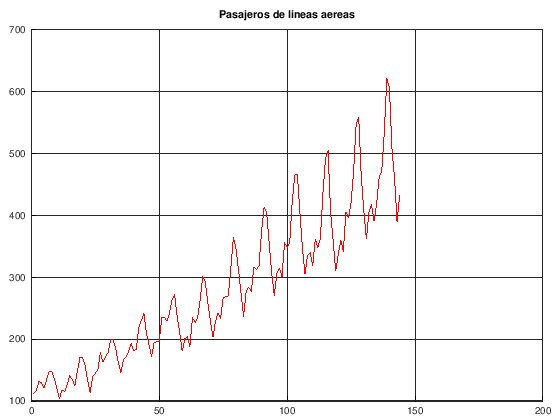

In [27]:
%plot --format png
figure(1)
grid on
hold on
title('Pasajeros de lineas aereas') % fallan los acentos
plot(airpas, 'r')

In [28]:
#close(1) % por si generamos la figura en una ventana y la queremos cerrar después

En `PaP` guadaremos un vector con los periodos correspondientes a la estacionalidad para datos mensuales:

In [29]:
PaP=[Inf, 30, 12./(1:6)]

PaP =

     Inf   30.00   12.00    6.00    4.00    3.00    2.40    2.00



esta serie es un tanto especial, pues el pico espectral correspondiente al periodo 2 es muy ténue (o inexistente), por ello vamos a poner dos ceros para ese componente DHR (para que no trate de identificarlo). Si no lo hacemos así, identificará un modelo para la tendencia más volatil al tratar de ajustar un componente a las oscilaciones de periodo 2 (con la serie en logaritmos si se identifica un modelo IRW para la tendencia incluso si incormporamos el componente de periodo 2).

In [30]:
TVPaP=[1 1 1 1 1 1 1 0;1 0 0 0 0 0 0 0]

TVPaP =

   1.00   1.00   1.00   1.00   1.00   1.00   1.00      0
   1.00      0      0      0      0      0      0      0



In [31]:
[VAR,P,TVP,oar]=autodhr(y,12,[],[],PaP,TVPaP,[28:32]) % la primera vez que lo ejecutemos nos dará unos warnings (luego no)

    lsqnonneg at line 187 column 7
    autodhr at line 328 column 15

    lsqnonneg at line 187 column 7
    autodhr at line 328 column 15

    lsqnonneg at line 187 column 7
    autodhr at line 328 column 15

    lsqnonneg at line 187 column 7
    autodhr at line 328 column 15

    lsqnonneg at line 187 column 7
    autodhr at line 328 column 15

    lsqnonneg at line 187 column 7
    autodhr at line 328 column 15

    lsqnonneg at line 187 column 7
    autodhr at line 328 column 15

    lsqnonneg at line 187 column 7
    autodhr at line 328 column 15

VAR =

   17.03    0.07    0.58    6.98    1.00    0.45    0.29    0.49    0.00

P =

     Inf   30.00   12.00    6.00    4.00    3.00    2.40    2.00

TVP =

   1.00   1.00   1.00   1.00   1.00   1.00   1.00      0
   1.00      0      0      0      0      0      0      0

oar = 30.00


Podemos calcular los ratios de varianzas (NVR) del siguiente modo:

In [32]:
NVR=VAR(2:8)./VAR(1)

NVR =

   0.00   0.03   0.41   0.06   0.03   0.02   0.03



Vamos a filtrar los componentes con el modelo identificado

In [33]:
filt=0;
[trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,12,filt,0);

In [34]:
trend

trend =

   121.96   119.02     2.94
   122.86   120.12     2.74
   123.64   121.23     2.41
   124.28   122.34     1.95
   124.92   123.46     1.46
   125.43   124.58     0.85
   125.92   125.71     0.20
   126.39   126.87    -0.48
   126.98   128.05    -1.07
   127.66   129.27    -1.61
   128.51   130.53    -2.02
   129.44   131.82    -2.39
   130.50   133.17    -2.66
   131.76   134.57    -2.81
   133.33   136.06    -2.73
   135.04   137.61    -2.57
   137.02   139.25    -2.24
   139.14   140.98    -1.84
   141.59   142.81    -1.23
   144.13   144.73    -0.59
   146.75   146.72     0.03
   149.44   148.80     0.64
   152.10   150.95     1.15
   154.78   153.18     1.60
   157.50   155.49     2.01
   160.12   157.86     2.26
   162.59   160.27     2.32
   165.00   162.73     2.28
   167.20   165.21     1.99
   169.35   167.71     1.64
   171.20   170.21     0.99
   173.07   172.73     0.35
   174.92   175.25    -0.34
   176.81   177.78    -0.97
   178.69   180.28    -1.59
   180.63  

Visualicemos los componentes

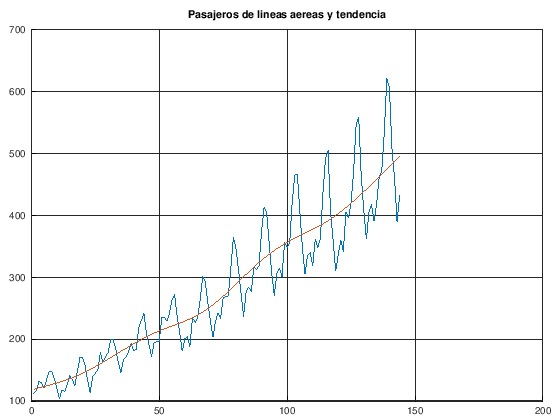

In [35]:
#figure(1)
grid on
hold on
title('Pasajeros de lineas aereas y tendencia')
plot([y,trend(:,2)])

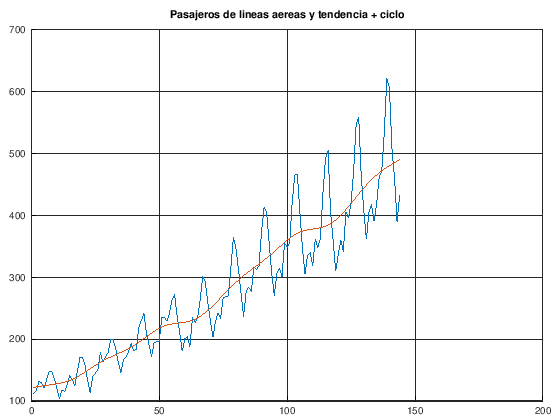

In [36]:
grid on
hold on
title('Pasajeros de lineas aereas y tendencia + ciclo')
plot([y,trend(:,1)])

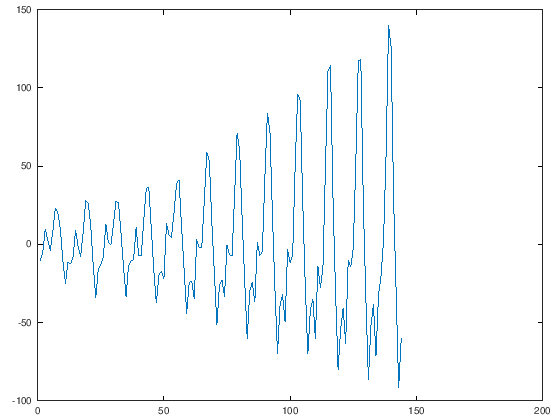

In [37]:
plot([season])

no hemos indicado componente para un ciclo (frecuencia intermedia entre la tendencia (0) y la frecuencia del primer armónico estacional)

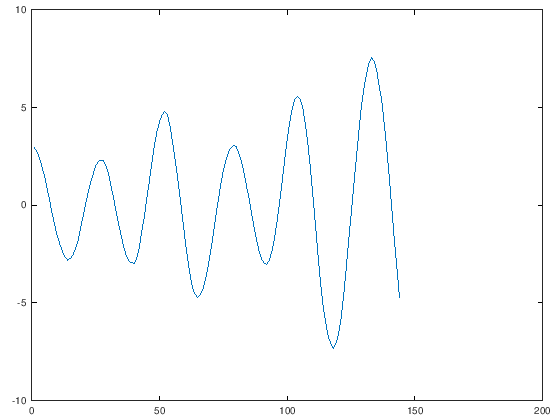

In [38]:
plot(cycle) # de periodo de arrededor de 30 meses

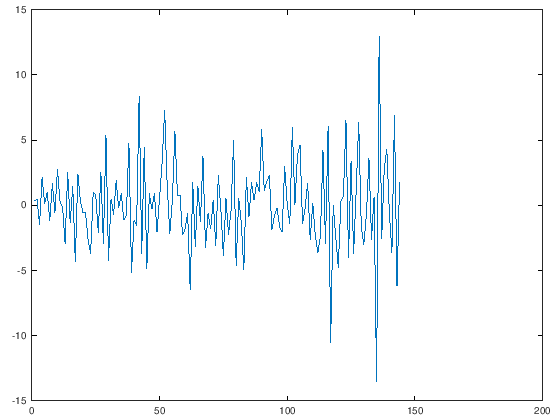

In [39]:
plot(irreg)

Pintemos la serie desestacionalizada `(trend + irreg`)

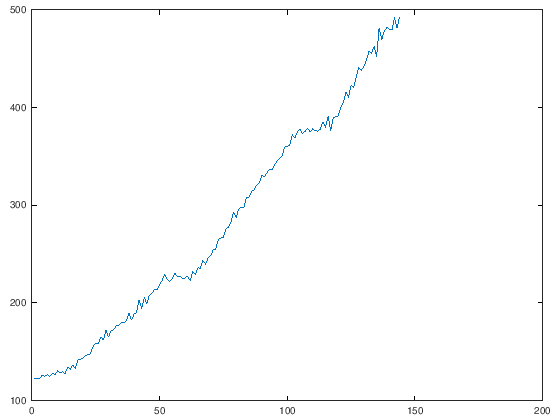

In [40]:
APsa = trend(:,1)+irreg;
plot(APsa)

In [41]:
filt=2;  % distinta rutina de filtrado que nos devuelve cada armónico por separado
[trend2,seasonH,cycle2,irreg2]=dhrfilt(y,P,TVP,VAR,12,filt,0);

ahora `season` es una matriz cuyas columnas son los armónicos estimados

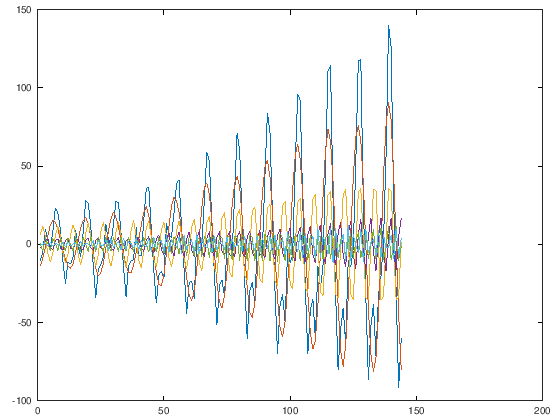

In [42]:
plot(seasonH)

Ahora vemos la primera diferencia de la tendencia estimada:

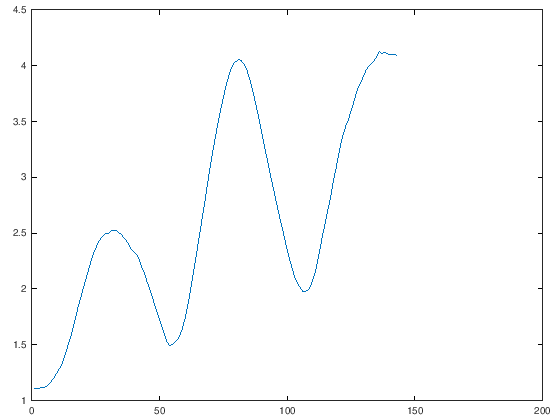

In [43]:
dtrend=diff(trend(:,2)); # diferencia del la tendencia sin el ciclo de 30 meses
plot(dtrend)

In [44]:
mkdir estimacionesAP

format bank

function Y = colData (cabecera,data)
    datos = num2str(data,"%5.5f");
    Y = cat(1,strjoin ({cabecera,blanks(size(datos,2)-size(cabecera,2)-1)}), datos);
endfunction

sep=repmat(' ',[size(AP,1),3]);

save("-ascii", "estimacionesAP/AP.dat",        "airpas")
save("-ascii", "estimacionesAP/APtrend.dat",   "trend")
save("-ascii", "estimacionesAP/APseason.dat",  "season")
save("-ascii", "estimacionesAP/APseasonH.dat", "seasonH")
save("-ascii", "estimacionesAP/APirreg.dat",   "irreg")
save("-ascii", "estimacionesAP/APsa.dat",      "APsa")

AP       = colData("AP",      airpas);
APtrend  = colData("APtrend",  trend);
APseason = colData("APseason",season);
APirreg  = colData("APirreg",  irreg);
APsa     = colData("APsa",      APsa);

AP_COMP_fechas=[timefmt4(12,1949,1,size(y,1)),sep, AP,sep, APtrend,sep, APseason,sep, APirreg,sep APsa];
%save("-ascii", "estimacionesAP/AP_COMP_fechas.dat",      "AP_COMP_fechas")

AP_COMP_fechas

AP_COMP_fechas =

obs            AP          APtrend                      APseason    APirreg     APsa     
1949-01-01     112.00000   121.95674119.015592.94115    -10.29697   0.34023     122.29697
1949-02-01     118.00000   122.86225120.122702.73955    -5.32788    0.46564     123.32788
1949-03-01     132.00000   123.63507121.229812.40526    9.86796     -1.50303    122.13204
1949-04-01     129.00000   124.28489122.339771.94512    2.58886     2.12625     126.41114
1949-05-01     121.00000   124.91549123.459011.45649    -4.03491    0.11942     125.03491
1949-06-01     135.00000   125.43218124.580370.85182    8.58939     0.97843     126.41061
1949-07-01     148.00000   125.91706125.713980.20308    23.26559    -1.18265    124.73441
1949-08-01     148.00000   126.39183126.86727-0.47544   19.96054    1.64762     128.03946
1949-09-01     136.00000   126.98464128.05325-1.06861   9.58194     -0.56658    126.41806
1949-10-01     119.00000   127.65978129.27142-1.61164   -11.41400   2.75422     13